**Configure Devices**

In [1]:
import sys
import tensorflow as tf
sys.path.append('./rcwa_tf/src/')
import tf_utils

In [2]:
# Limit GPU memory growth
tf_utils.config_gpu_memory_usage()

# Choose the device to run on
use_gpu = True
tfDevice = '/job:localhost/replica:0/task:0/device:GPU:1' if use_gpu else '/CPU:0'
print('Executing on device ' + tfDevice + ' ...')

# Measure GPU memory usage
gpu_memory_init = tf_utils.gpu_memory_info()

 
2 Physical GPUs
Executing on device /job:localhost/replica:0/task:0/device:GPU:1 ...


**Dependencies**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pdb
import solver
import solver_metasurface
import rcwa_utils
import tensor_utils

**Loss Function Definition**

In [4]:
def focal_spot(z, device, params):

    # Generate permittivity and permeability distributions.
    ER_t, UR_t = solver_metasurface.generate_copilot_metasurface_multilayer(z, device, params)

    # Simulate the system.
    outputs = solver.simulate(ER_t, UR_t, params)

    # First loss term: maximize sum of electric field magnitude within some radius of the desired focal point.
    r = params['focal_spot_radius']
    field = outputs['ty'][:, :, :, np.prod(params['PQ']) // 2, 0]
    focal_plane = solver.propagate(params['input'] * field, params['propagator'], params['upsample'])
    index = (params['pixelsX'] * params['upsample']) // 2
    l1 = tf.math.reduce_sum(tf.abs(focal_plane[0, index-r:index+r, index-r:index+r]))

    # Second loss term: minimize sum of electric field magnitude elsewhere.
    l2 = tf.math.reduce_sum(tf.abs(focal_plane[0, :, :])) - l1

    # Final loss: (negative) field intensity at focal point + field intensity elsewhere.
    return -params['w_l1']*l1 + params['w_l2']*l2

**Optimize Single Layer Function Definition**

In [5]:
def constrain_gradients(g, device):
    
    # Enforce 'no tunnels' rule by setting gradients of pixels above void to 0.
    # Note: Probably does not work when using random initialization.
    #mask = (device[0,:,:,0,0,0] > 1.0)[:,:,tf.newaxis]
    #return g * tf.cast(mask, tf.float32)
    return g

In [6]:
def optimize_layer(device, Nlay):
    
    # Initialize and populate dictionary of parameters.
    params = solver.initialize_params(wavelengths=wavelengths, thetas=thetas, phis=phis,
                                  pte=pte, ptm=ptm,
                                  pixelsX=pixelsX, pixelsY=pixelsY,
                                  erd=erd, ers=ers, PQ=PQ,
                                  Lx=Lx, Ly=Ly,
                                  L=L[:Nlay], Nx=Nx,
                                  eps_min=eps_min, eps_max=eps_max)

    params['N'] = N
    params['w_l1'] = w_l1
    params['w_l2'] = w_l2
    params['thresholding_enabled'] = thresholding_enabled
    params['sigmoid_coeff'] = sigmoid_coeff
    params['sigmoid_update'] = sigmoid_update
    params['learning_rate'] = learning_rate
    params['focal_spot_radius'] = focal_spot_radius
    params['random_init'] = random_init
    params['debug'] = debug

    # Define the free-space propagator and input field distribution for the metasurface.
    params['f'] = 1.0 * params['Lx'] * params['pixelsX']
    params['upsample'] = upsample
    params['propagator'] = solver.make_propagator(params, params['f'])
    params['input'] = solver.define_input_fields(params)

    # Get initial permittivity profile for the top layer of the metasurface.
    z_initial = solver_metasurface.init_copilot_metasurface(params, single_layer=True)
    z = tf.Variable(z_initial, dtype=tf.float32)
    
    # Define an optimizer and data to be stored.
    opt = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    loss = np.zeros(params['N'] + 1)
    
    # Optimize.
    print('Optimizing... Iteration ', end="")
    
    i = 0
    while i < params['N']:
        print(str(i) + ', ', end="")
        
        # Calculate gradients.
        with tf.GradientTape() as tape:
            l = focal_spot(z, device, params)
            grads = tape.gradient(l, [z])
        
        # Modify gradients to adhere to problem constraints.
        constrained_grads = [constrain_gradients(g, device) for g in grads]
        
        # Apply gradients to variables.
        opt.apply_gradients(zip(constrained_grads, [z]))
        
        loss[i] = l.numpy()
        
        # Anneal sigmoid coefficient.
        params['sigmoid_coeff'] += params['sigmoid_update']
            
        # Increment loop counter.
        i += 1
    
    print('Maximum iterations reached.')
        
    # Round off to a final, admissable, solution.
    if params['thresholding_enabled']:
        
        # Sigmoid pass.
        z = tf.math.sigmoid(params['sigmoid_coeff'] * (z - (1 + (params['erd']-1)/2)) )
        z = 1 + (params['erd'] - 1) * z
    
        # Convert to binary solution.
        z = tf.cast(z > ((params['eps_min'] + params['eps_max'])/2), tf.float32) \
            * (params['eps_max'] - params['eps_min']) + params['eps_min']
    
    # Get final loss.
    loss[i] = focal_spot(z, device, params).numpy()
    print('Final Loss: ' + str(loss[i]))
    
    return z, loss, params

**Optimize Multiple Layers Function Definition**

In [7]:
def optimize_multiple_layers(l):
    
    # Initalize list of losses.
    loss = np.array([])
    
    # Initialize pixel representation of metasurface.
    z = tf.reshape(tf.constant([], dtype=tf.float32),(pixelsX, pixelsY, 0))
    
    # Initialize the device as just the substrate layer.
    layer_shape = (batchSize, pixelsX, pixelsY, 1, Nx, Ny)
    device = ers * tf.ones(layer_shape, dtype = tf.float32)
    
    # For each layer to be optimized...
    for i in range(l):
        print('Layer ' + str(i) + ':')
        
        # Optimize the top layer.
        z_i, loss_i, params = optimize_layer(device, i+2)
        
        # Accumulate the losses.
        loss = np.concatenate((loss,loss_i))
        
        # Accumulate pixel representation of the layers.
        z = tf.concat(values = [z_i, z], axis = 2)
   
        # When optimizing the next layer, the current layer becomes part of the device,
        # meaning it is no longer optimized.
        z_i_stacked, u = solver_metasurface.pixel_to_stacked(z_i, params, add_substrate=False, cast=False)
        device = tf.concat(values = [z_i_stacked, device], axis = 3)
    
    return z, loss, params

**Initialize Parameters**

In [8]:
with tf.device(tfDevice):
    
    # Source parameters.
    wavelengths = [632.0]
    thetas = [0.0]
    phis = [0.0]
    pte = [1.0]
    ptm = [0.0]
    batchSize = len(wavelengths)
    
    # Device parmeters.
    pixelsX = 25
    pixelsY = pixelsX
    erd = 6.76
    ers = 2.25
    eps_min = 1.0
    eps_max = erd
    L = [632.0] * 6
    Nlay = 2 # Nlay begins at 2, but is incremented as optimization progresses.
    Lx = 0.7 * 632.0
    Ly = Lx
    
    # Solver parameters.
    PQ = [5,5]
    Nx = 16
    Ny = Nx
    upsample = 11
    
    # Problem parameters.
    N = 100
    w_l1 = 1.0
    w_l2 = 0.0
    thresholding_enabled = True
    sigmoid_coeff = 1.0
    sigmoid_update = 20.0 / N
    learning_rate = 1E-0
    focal_spot_radius = 10
    random_init = False
    debug = False

**Optimize**

In [9]:
with tf.device(tfDevice):
    
    # Initialize the device as just the substrate layer.
    layer_shape = (batchSize, pixelsX, pixelsY, 1, Nx, Ny)
    device = ers * tf.ones(layer_shape, dtype = tf.float32)
        
    # Optimize a device with a single layer (plus a substrate layer).
    #z, loss, params = optimize_layer(device, 2)
    
    # Optimize a device with two layers (plus a substrate layer).
    z, loss, params = optimize_multiple_layers(2)
    

Layer 0:
Optimizing... Iteration 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, Maximum iterations reached.
Final Loss: -1077.426513671875
Layer 1:
Optimizing... Iteration 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, Maximum iterations reached.
Final Loss: -1330.653076171875


**Display Learning Curve**

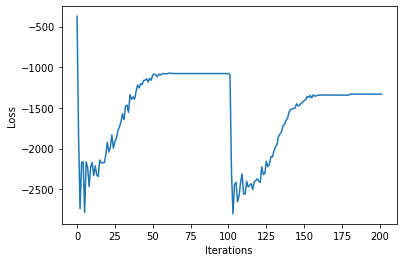

In [10]:
with tf.device(tfDevice):
    
    plt.plot(loss)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

**Display Resulting Intensity on the Focal Plane**

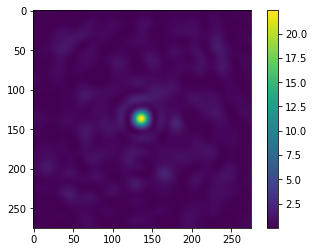

In [11]:
with tf.device(tfDevice):
    
    ER_t, UR_t = solver_metasurface.pixel_to_stacked(z, params)
    outputs = solver.simulate(ER_t, UR_t, params)
    field = outputs['ty'][:, :, :, np.prod(params['PQ']) // 2, 0]
    focal_plane = solver.propagate(params['input'] * field, params['propagator'], params['upsample'])
    plt.imshow(tf.abs(focal_plane[0, :, :]) ** 2)
    plt.colorbar()

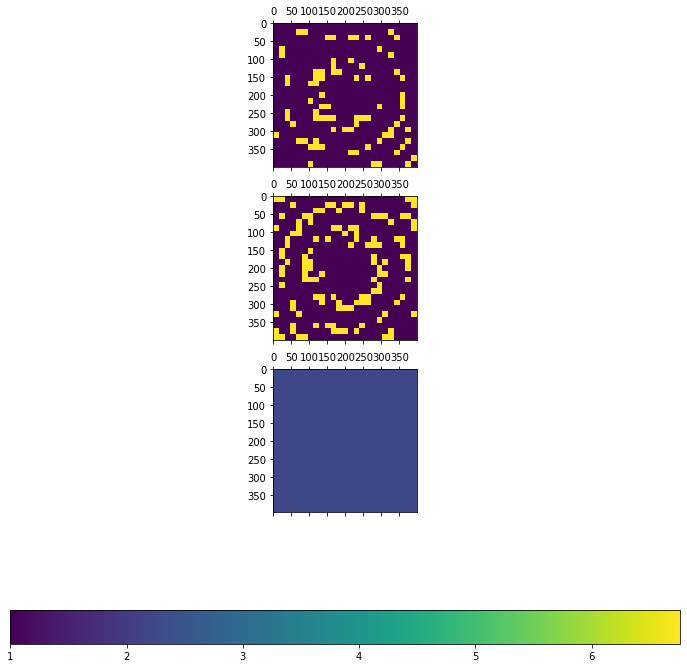

In [12]:
with tf.device(tfDevice):
    
    solver_metasurface.display_metasurface(ER_t, params)

***Check GPU Memory Utilization***

In [13]:
gpu_memory_final = tf_utils.gpu_memory_info()
gpu_memory_used = [gpu_memory_final[1][0] - gpu_memory_init[1][0], gpu_memory_final[1][1] - gpu_memory_init[1][1]]
print('Memory used on each GPU(MiB): ' + str(gpu_memory_used))

Memory used on each GPU(MiB): [10341, 417]
